# Model 1:

### Target:

- Get the set-up right.
- Set Transforms.
- Set Data Loader.
- Set Basic Working Code.
- Set Basic Training  & Test Loop.

### Results:

- Parameters: 6.3M
- Best Training Accuracy: 99.93
- Best Test Accuracy: 99.26

### Analysis:

- Extremely Heavy Model for such a problem.
- Model is over-fitting, but we are changing our model in the next step.


# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import warnings
warnings.filterwarnings("ignore")

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
from utils import load_data

train, test = load_data(train_transforms, test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


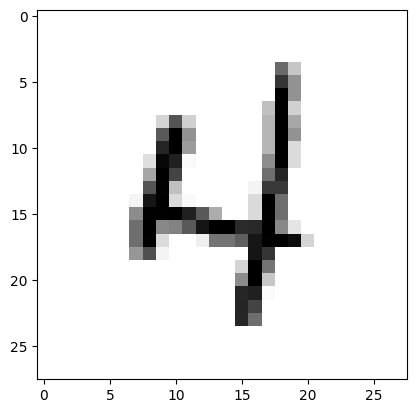

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

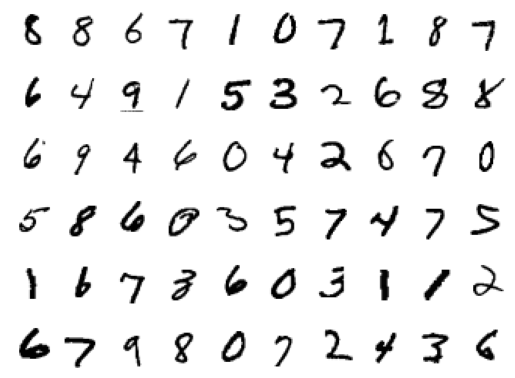

In [6]:
from utils import plot_images
plot_images(images)

# The model
Let's import our model from `model.py` file

In [7]:
from model import Model1 as Net

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
--------------------------------

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's import train and test functions from `model.py` file

In [9]:
from model import train, test

# Let's Train and test our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_losses = []
test_losses = []
train_acc = []
test_acc = []

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, train_losses, train_acc)
    test(model, device, test_loader, test_losses, test_acc)

EPOCH: 0


Loss=0.05240306258201599 Batch_id=468 Accuracy=88.05: 100%|██████████████████████████| 469/469 [00:14<00:00, 32.15it/s]



Test set: Average loss: 0.0620, Accuracy: 9796/10000 (97.96%)

EPOCH: 1


Loss=0.02066131867468357 Batch_id=468 Accuracy=98.41: 100%|██████████████████████████| 469/469 [00:15<00:00, 31.11it/s]



Test set: Average loss: 0.0353, Accuracy: 9872/10000 (98.72%)

EPOCH: 2


Loss=0.056589048355817795 Batch_id=468 Accuracy=98.90: 100%|█████████████████████████| 469/469 [00:14<00:00, 31.87it/s]



Test set: Average loss: 0.0331, Accuracy: 9884/10000 (98.84%)

EPOCH: 3


Loss=0.005516443867236376 Batch_id=468 Accuracy=99.22: 100%|█████████████████████████| 469/469 [00:14<00:00, 31.54it/s]



Test set: Average loss: 0.0277, Accuracy: 9911/10000 (99.11%)

EPOCH: 4


Loss=0.008954138495028019 Batch_id=468 Accuracy=99.46: 100%|█████████████████████████| 469/469 [00:14<00:00, 31.70it/s]



Test set: Average loss: 0.0272, Accuracy: 9904/10000 (99.04%)

EPOCH: 5


Loss=0.0050966572016477585 Batch_id=468 Accuracy=99.53: 100%|████████████████████████| 469/469 [00:15<00:00, 31.02it/s]



Test set: Average loss: 0.0255, Accuracy: 9914/10000 (99.14%)

EPOCH: 6


Loss=0.03622559458017349 Batch_id=468 Accuracy=99.67: 100%|██████████████████████████| 469/469 [00:15<00:00, 30.79it/s]



Test set: Average loss: 0.0300, Accuracy: 9912/10000 (99.12%)

EPOCH: 7


Loss=0.003608567640185356 Batch_id=468 Accuracy=99.71: 100%|█████████████████████████| 469/469 [00:15<00:00, 30.85it/s]



Test set: Average loss: 0.0272, Accuracy: 9922/10000 (99.22%)

EPOCH: 8


Loss=0.0035657307598739862 Batch_id=468 Accuracy=99.75: 100%|████████████████████████| 469/469 [00:15<00:00, 31.03it/s]



Test set: Average loss: 0.0293, Accuracy: 9914/10000 (99.14%)

EPOCH: 9


Loss=0.000737183669116348 Batch_id=468 Accuracy=99.85: 100%|█████████████████████████| 469/469 [00:15<00:00, 30.97it/s]



Test set: Average loss: 0.0275, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.00865247193723917 Batch_id=468 Accuracy=99.84: 100%|██████████████████████████| 469/469 [00:15<00:00, 31.13it/s]



Test set: Average loss: 0.0285, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=0.0013569867005571723 Batch_id=468 Accuracy=99.86: 100%|████████████████████████| 469/469 [00:15<00:00, 31.20it/s]



Test set: Average loss: 0.0265, Accuracy: 9920/10000 (99.20%)

EPOCH: 12


Loss=5.915553992963396e-05 Batch_id=468 Accuracy=99.88: 100%|████████████████████████| 469/469 [00:14<00:00, 31.81it/s]



Test set: Average loss: 0.0268, Accuracy: 9925/10000 (99.25%)

EPOCH: 13


Loss=0.000246668845647946 Batch_id=468 Accuracy=99.92: 100%|█████████████████████████| 469/469 [00:13<00:00, 34.77it/s]



Test set: Average loss: 0.0347, Accuracy: 9926/10000 (99.26%)

EPOCH: 14


Loss=0.002328566275537014 Batch_id=468 Accuracy=99.93: 100%|█████████████████████████| 469/469 [00:13<00:00, 34.67it/s]



Test set: Average loss: 0.0367, Accuracy: 9919/10000 (99.19%)



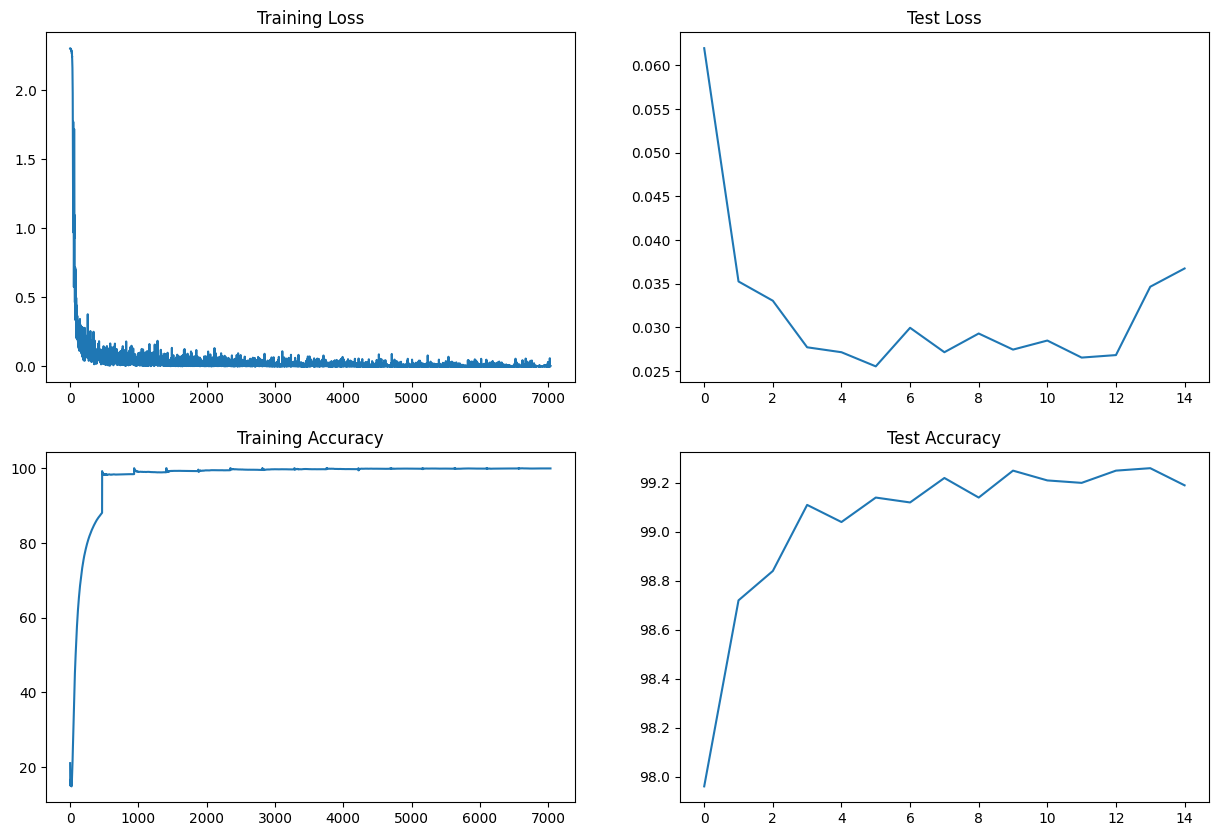

In [11]:
from utils import plot_graphs

plot_graphs(train_acc, train_losses, test_acc, test_losses)